baseline思路：使用CNN进行定长字符分类；

运行系统要求：Python2/3，内存4G，有无GPU都可以

In [1]:
# 1.下载街景字符识别的数据集，并且解压

import pandas as pd
import os
import requests
import zipfile
import shutil
import shutil

from google.colab import drive
drive.mount('/content/drive')
!ls -l /content/drive/MyDrive

links = pd.read_csv('/content/drive/MyDrive/mchar_data_list_0515.csv')
dir_name = 'NDataset'
mypath = '/content/'
if not os.path.exists(mypath + dir_name):
    os.mkdir(mypath + dir_name)
for i,link in enumerate(links['link']):
    file_name = links['file'][i]
    print(file_name, '\t', link)
    file_name = mypath + dir_name + '/' + file_name
    if not os.path.exists(file_name):
        response = requests.get(link, stream=True)
        with open( file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
zip_list = ['mchar_train', 'mchar_test_a', 'mchar_val']
for little_zip in zip_list:
    if not os.path.exists(mypath + dir_name + '/' + little_zip):
        zip_file = zipfile.ZipFile(mypath + dir_name + '/' + little_zip + '.zip', 'r')
        zip_file.extractall(path = mypath + dir_name )
if os.path.exists(mypath + dir_name + '/' + '__MACOSX'):
    shutil.rmtree(mypath + dir_name + '/' + '__MACOSX')

Mounted at /content/drive
total 153553
drwx------ 2 root root      4096 Feb 27 15:05 'Colab Notebooks'
drwx------ 2 root root      4096 Mar 22 07:35  mchar
-rw------- 1 root root       659 Mar 22 07:35  mchar_data_list_0515.csv
-rw------- 1 root root 141581580 Mar 19 18:19  model_best.pth
-rw------- 1 root root  15646679 Mar 19 17:25  tmp.csv
mchar_train.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.zip
mchar_train.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
mchar_val.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.zip
mchar_val.json 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
mchar_test_a.zip 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_test_a.zip
mchar_sample_submit_A.csv 	 http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_sample_submit_A.csv


In [2]:
#2.定义目录路径
data_dir = {
    'train_data': '/content/NDataset/mchar_train/',
    'val_data': '/content/NDataset/mchar_val/',
    'test_data': '/content/NDataset/mchar_test_a/',
    'train_label': '/content/NDataset/mchar_train.json',
    'val_label': '/content/NDataset/mchar_val.json',
    'submit_file': '/content/NDataset/mchar_sample_submit_A.csv'
}
#3.统计train,val,test数据集的个数
from glob import glob
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def data_summary():
  train_list = glob(data_dir['train_data']+'*.png')
  test_list = glob(data_dir['test_data']+'*.png')
  val_list = glob(data_dir['val_data']+'*.png')
  print('train image counts: %d'%len(train_list))
  print('val image counts: %d'%len(val_list))
  print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [3]:
#4.看train数据集第一张的信息，长宽高等
def look_train_json():
  with open(data_dir['train_label'], 'r', encoding='utf-8') as f:
    content = f.read()

  content = json.loads(content)

  print(content['000000.png'])

look_train_json()
#5.看需要输出文件的信息
def look_submit():
  df = pd.read_csv(data_dir['submit_file'], sep=',')
  print(df.head(5))

look_submit()

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}
    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


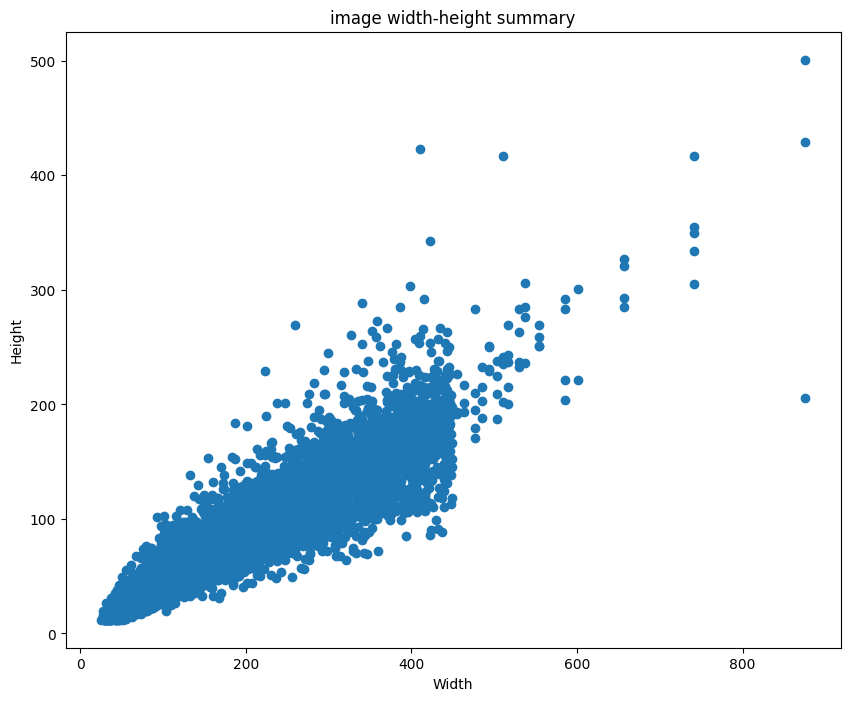

In [4]:
#6.统计图片的大小
def img_size_summary():
  sizes = []

  for img in glob(data_dir['train_data']+'*.png'):
    img = Image.open(img)

    sizes.append(img.size)

  sizes = np.array(sizes)

  plt.figure(figsize=(10, 8))
  plt.scatter(sizes[:, 0], sizes[:, 1])
  plt.xlabel('Width')
  plt.ylabel('Height')

  plt.title('image width-height summary')
  plt.show()

img_size_summary()

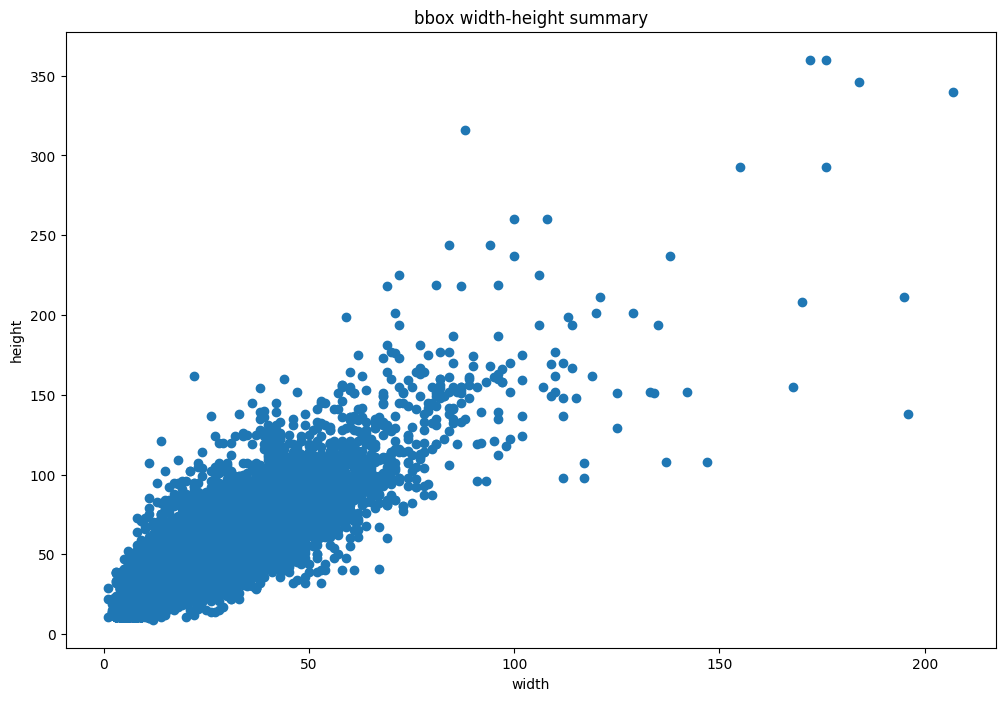

In [5]:
#7.统计bbox的大小
def bbox_summary():
  marks = json.loads(open(data_dir['train_label'], 'r').read())
  bboxes = []

  for img, mark in marks.items():
    for i in range(len(mark['label'])):
      bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

  bboxes = np.array(bboxes)

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(bboxes[:, 2], bboxes[:, 3])
  ax.set_title('bbox width-height summary')
  ax.set_xlabel('width')
  ax.set_ylabel('height')
  plt.show()

bbox_summary()

In [6]:
#8.统计图片分别含有数字的个数
def label_summary():
    marks = json.load(open(data_dir['train_label'], 'r'))

    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1

    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d' % (k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


In [7]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm, tqdm_notebook

%pylab inline

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 定义读取数据集

In [8]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        lbl = np.array(self.img_label[index], dtype=np.int64)
        lbl = list(lbl)  + (5 - len(lbl)) * [10]
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

# 定义读取数据dataloader

假设数据存放在`../input`文件夹下，并进行解压。

In [9]:
train_path = glob.glob('./NDataset/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('./NDataset/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path), len(train_label))

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=40,
    shuffle=True,
    num_workers=10,
)

val_path = glob.glob('./NDataset/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('./NDataset/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]
print(len(val_path), len(val_label))

val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=40,
    shuffle=False,
    num_workers=10,
)

30000 30000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


10000 10000


# 定义分类模型

这里使用ResNet18的模型进行特征提取

In [10]:
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()

        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv

        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)

    def forward(self, img):
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for i, (input, target) in enumerate(train_loader):
        if use_cuda:
            input = input.cuda()
            target = target.cuda()

        c0, c1, c2, c3, c4 = model(input)
        loss = criterion(c0, target[:, 0]) + \
                criterion(c1, target[:, 1]) + \
                criterion(c2, target[:, 2]) + \
                criterion(c3, target[:, 3]) + \
                criterion(c4, target[:, 4])

        # loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)

def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if use_cuda:
                input = input.cuda()
                target = target.cuda()

            c0, c1, c2, c3, c4 = model(input)
            loss = criterion(c0, target[:, 0]) + \
                    criterion(c1, target[:, 1]) + \
                    criterion(c2, target[:, 2]) + \
                    criterion(c3, target[:, 3]) + \
                    criterion(c4, target[:, 4])
            # loss /= 6
            val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None

    # TTA 次数
    for _ in range(tta):
        test_pred = []

        with torch.no_grad():
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()

                c0, c1, c2, c3, c4 = model(input)
                if use_cuda:
                    output = np.concatenate([
                        c0.data.cpu().numpy(),
                        c1.data.cpu().numpy(),
                        c2.data.cpu().numpy(),
                        c3.data.cpu().numpy(),
                        c4.data.cpu().numpy()], axis=1)
                else:
                    output = np.concatenate([
                        c0.data.numpy(),
                        c1.data.numpy(),
                        c2.data.numpy(),
                        c3.data.numpy(),
                        c4.data.numpy()], axis=1)

                test_pred.append(output)

        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred

    return test_pred_tta

# 训练与验证

In [ ]:
model = SVHN_Model1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

use_cuda = True
if use_cuda:
    model = model.cuda()

for epoch in range(10):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)

    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict(val_loader, model, 1)
    val_predict_label = np.vstack([
        val_predict_label[:, :11].argmax(1),
        val_predict_label[:, 11:22].argmax(1),
        val_predict_label[:, 22:33].argmax(1),
        val_predict_label[:, 33:44].argmax(1),
        val_predict_label[:, 44:55].argmax(1),
    ]).T
    val_label_pred = []
    for x in val_predict_label:
        val_label_pred.append(''.join(map(str, x[x!=10])))

    val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))

    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, train_loss, val_loss))
    print('Val Acc', val_char_acc)
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        # print('Find better model in Epoch {0}, saving model.'.format(epoch))
        torch.save(model.state_dict(), './model.pt')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.8MB/s]


Epoch: 0, Train loss: 3.522018853823344 	 Val loss: 3.737295904159546
Val Acc 0.3263
Epoch: 1, Train loss: 2.249884195725123 	 Val loss: 3.028111908912659
Val Acc 0.4253
Epoch: 2, Train loss: 1.89911790283521 	 Val loss: 2.7823858065605163
Val Acc 0.4683
Epoch: 3, Train loss: 1.6907717207272848 	 Val loss: 2.86510116147995
Val Acc 0.4611
Epoch: 4, Train loss: 1.523663246234258 	 Val loss: 2.705325701713562
Val Acc 0.4937
Epoch: 5, Train loss: 1.4300730171998342 	 Val loss: 2.516483167886734
Val Acc 0.5329
Epoch: 6, Train loss: 1.326773999651273 	 Val loss: 2.698635828495026
Val Acc 0.5069


# 预测并生成提交文件

In [ ]:
test_path = glob.glob('../input/test_a/*.png')
test_path.sort()
test_json = json.load(open('../input/test_a.json'))
test_label = [[1]] * len(test_path)
print(len(test_path), len(test_label))

test_loader = torch.utils.data.DataLoader(
    SVHNDataset(test_path, test_label,
                transforms.Compose([
                    transforms.Resize((70, 140)),
                    # transforms.RandomCrop((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=40,
    shuffle=False,
    num_workers=10,
)

40000 40000


In [ ]:
# 加载保存的最优模型
model.load_state_dict(torch.load('model.pt'))

test_predict_label = predict(test_loader, model, 1)
print(test_predict_label.shape)

test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
test_predict_label = np.vstack([
    test_predict_label[:, :11].argmax(1),
    test_predict_label[:, 11:22].argmax(1),
    test_predict_label[:, 22:33].argmax(1),
    test_predict_label[:, 33:44].argmax(1),
    test_predict_label[:, 44:55].argmax(1),
]).T

test_label_pred = []
for x in test_predict_label:
    test_label_pred.append(''.join(map(str, x[x!=10])))

import pandas as pd
df_submit = pd.read_csv('../input/test_A_sample_submit.csv')
df_submit['file_code'] = test_label_pred
df_submit.to_csv('submit.csv', index=None)

(40000, 55)


#deepseek优化后的代码

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

class SVHNTrainer:
    def __init__(self, model, criterion, optimizer, device='cuda', use_amp=True):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scaler = GradScaler(enabled=use_amp)

        # 训练记录
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_acc = 0.0

    def _compute_loss(self, outputs, targets):
        """多任务损失计算"""
        return sum(self.criterion(o, targets[:, i]) for i, o in enumerate(outputs))

    def _move_data(self, data):
        """自动数据迁移"""
        if isinstance(data, (list, tuple)):
            return [self._move_data(x) for x in data]
        return data.to(self.device, non_blocking=True)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0

        with tqdm(train_loader, desc=f"Training", unit="batch") as pbar:
            for inputs, targets in pbar:
                # 数据迁移
                inputs = self._move_data(inputs)
                targets = self._move_data(targets.long())  # 确保标签为long类型

                # 梯度清零
                self.optimizer.zero_grad(set_to_none=True)

                # 混合精度训练
                with autocast(enabled=self.scaler.is_enabled()):
                    outputs = self.model(inputs)
                    loss = self._compute_loss(outputs, targets)

                # 反向传播
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                # 记录损失
                batch_loss = loss.item()
                total_loss += batch_loss
                pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

        return total_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad(), tqdm(val_loader, desc="Validating", unit="batch") as pbar:
            for inputs, targets in pbar:
                inputs = self._move_data(inputs)
                targets = self._move_data(targets.long())

                outputs = self.model(inputs)
                loss = self._compute_loss(outputs, targets)

                # 计算准确率
                preds = torch.stack([o.argmax(dim=1) for o in outputs], dim=1)
                mask = (preds != 10)  # 过滤无效标签
                filtered_preds = [p[m] for p, m in zip(preds.permute(1,0), mask.permute(1,0))]
                filtered_targets = [t[m] for t, m in zip(targets.permute(1,0), mask.permute(1,0))]

                batch_correct = sum((p == t).sum().item() for p, t in zip(filtered_preds, filtered_targets))
                batch_total = sum(len(t) for t in filtered_targets)

                # 记录指标
                batch_loss = loss.item()
                total_loss += batch_loss
                correct += batch_correct
                total += batch_total
                pbar.set_postfix({"loss": f"{batch_loss:.4f}", "acc": f"{batch_correct/batch_total:.2%}"})

        return total_loss/len(val_loader), correct/total if total >0 else 0

    def visualize_training(self):
        """可视化训练过程"""
        plt.figure(figsize=(12, 5))

        # 损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # 准确率曲线
        plt.subplot(1, 2, 2)
        plt.plot(self.val_accuracies, label='Val Accuracy', color='orange')
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def predict(self, test_loader, tta=10):
        """TTA预测优化"""
        self.model.eval()
        all_preds = []

        for _ in range(tta):
            batch_preds = []
            with torch.no_grad():
                for inputs, _ in test_loader:
                    inputs = self._move_data(inputs)
                    outputs = self.model(inputs)
                    # 在GPU上拼接输出
                    pred = torch.stack([o.argmax(dim=1) for o in outputs], dim=1)
                    batch_preds.append(pred.cpu())

            all_preds.append(torch.cat(batch_preds).numpy())

        # 对TTA结果取众数
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=np.stack(all_preds))

# 初始化训练器
model = SVHN_Model1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = SVHNTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    use_amp=True
)

# 训练循环
EPOCHS = 10
patience = 3
for epoch in range(EPOCHS):
    train_loss = trainer.train_epoch(train_loader)
    val_loss, val_acc = trainer.validate(val_loader)

    # 记录指标
    trainer.train_losses.append(train_loss)
    trainer.val_losses.append(val_loss)
    trainer.val_accuracies.append(val_acc)

    # 打印进度
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2%}")

    # 保存最佳模型
    if val_acc > trainer.best_acc:
        trainer.best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy {val_acc:.2%}")
    else:
        print(f"No improvement in accuracy. Current best accuracy: {trainer.best_acc:.2%}")

    # 可视化
    trainer.visualize_training()

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 生成测试结果
test_preds = trainer.predict(test_loader, tta=10)